In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
import pickle

with open('df_final.pkl', 'rb') as file:
    df = pickle.load(file)

with open('df_test.pkl', 'rb') as file:
    test = pickle.load(file)

with open('df_train_resampled.pkl', 'rb') as file:
    train = pickle.load(file)

In [3]:
X_train = train[['Salemonth', 'ORGPRICE', 'AMT', 'amt_diff', 'retail_diff',
                 'BRAND_dummy_Affordable', 'BRAND_dummy_Luxury', 'ReturnRate']]
y_train = train['return']

X_test = test[['Salemonth', 'ORGPRICE', 'AMT', 'amt_diff', 'retail_diff',
               'BRAND_dummy_Affordable', 'BRAND_dummy_Luxury', 'ReturnRate']]
y_test = test['Returns']

In [4]:
from sklearn.impute import SimpleImputer

# Impute missing values in training and test sets
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid to search through
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}

# Create the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Define a scorer for the RandomizedSearchCV
scorer = make_scorer(accuracy_score)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=42, error_score='raise')
random_search.fit(X_train_imputed, y_train)

# Get the best model
best_model = random_search.best_estimator_

# Evaluate the best model on the test set
best_predictions = best_model.predict(X_test)

/Users/elsielin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


                  Feature  Importance
0               Salemonth    0.311406
7              ReturnRate    0.228581
2                     AMT    0.140330
1                ORGPRICE    0.122735
4             retail_diff    0.119064
3                amt_diff    0.069899
5  BRAND_dummy_Affordable    0.004085
6      BRAND_dummy_Luxury    0.003901


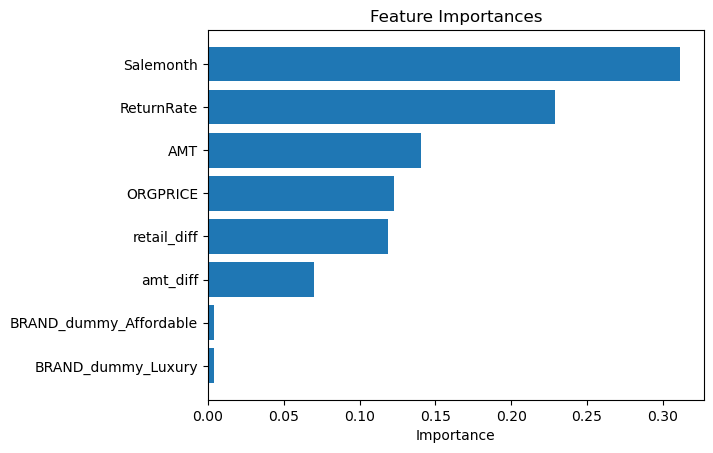

In [6]:
# Access feature importances from the best model
feature_importances = best_model.feature_importances_

features = ['Salemonth', 'ORGPRICE', 'AMT', 'amt_diff', 'retail_diff',
            'BRAND_dummy_Affordable', 'BRAND_dummy_Luxury', 'ReturnRate']

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

# Plotting feature importances
import matplotlib.pyplot as plt
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

* Salemonth (31.14%): Retains its significant influence as the most important feature in predicting returns, indicating that specific months or seasonal trends have a strong correlation with return rates.

* ReturnRate (22.86%): Emerges as a highly influential factor, implying that the return rate, possibly derived from historical return data or customer behavior, holds substantial predictive power for future returns.

* AMT (14.03%) and ORGPRICE (12.27%): Transactional attributes, such as the transaction amount and original price, maintain notable importance, suggesting that these monetary factors play a significant role in return predictions.

* retail_diff (11.91%) and amt_diff (6.99%): Show moderate importance, indicating that differences in transaction amounts and retail prices, potentially related to discounts or fluctuations, contribute meaningfully but to a lesser extent compared to other features.

* BRAND_dummy_Affordable (0.41%) and BRAND_dummy_Luxury (0.39%): Display minimal importance, implying that the categorization of the brand into affordable or luxury categories has limited impact on return predictions within this model.

In [7]:
best_model

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=42)

* `bootstrap=False`: The parameter indicates that bootstrap sampling during tree construction is turned off. In this scenario, the entire dataset is used to build each tree in the forest, making the model deterministic.

* `class_weight='balanced'`: This parameter deals with class imbalance by adjusting weights inversely proportional to class frequencies. In this case, it assigns higher weights to the minority class, aiming to balance class representation during training.

* `min_samples_leaf=2`: It determines the minimum number of samples required to be at a leaf node. With a value of 2, each leaf node in the trees must have at least two samples, which can help prevent the model from overfitting to noise.

* `min_samples_split=10`: This parameter sets the minimum number of samples required to split an internal node. It ensures that a node needs at least 10 samples to be considered for further splitting, controlling tree growth and preventing the creation of small, less meaningful splits.

* `n_estimators=200`: It sets the number of trees in the forest to 200. Having a higher number of trees can improve the model's performance by reducing overfitting and increasing stability, albeit at the cost of increased computation.

* `random_state=42`: This sets the seed for the random number generator, ensuring reproducibility. The same random_state will yield the same results each time you train the model, providing consistency in results.

/Users/elsielin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


AUC: 0.5926142599492641


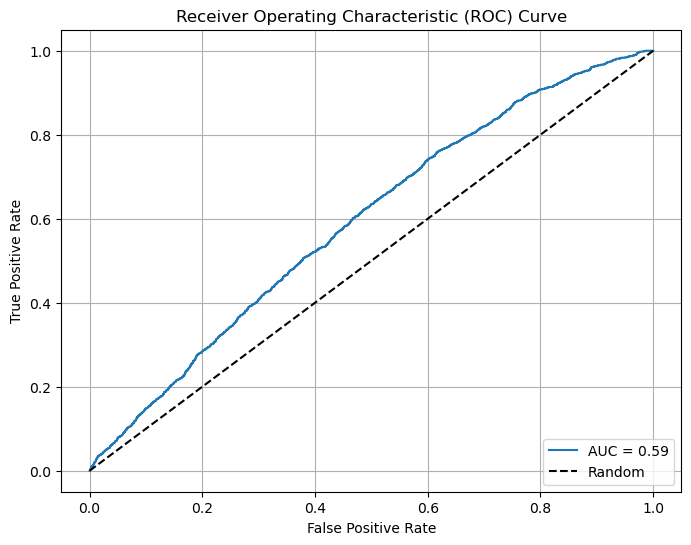

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class
y_probs = best_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_probs)
print(f"AUC: {auc}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [9]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, best_predictions)
conf_matrix

array([[14992,  3445],
       [ 1150,   413]])

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, best_predictions)
precision = precision_score(y_test, best_predictions)
recall = recall_score(y_test, best_predictions)
f1 = f1_score(y_test, best_predictions)

print(f"Best Model Accuracy: {accuracy}")
print(f"Best Model Precision: {precision}")
print(f"Best Model Recall: {recall}")
print(f"Best Model F1: {f1}")

Best Model Accuracy: 0.77025
Best Model Precision: 0.10705028512182478
Best Model Recall: 0.26423544465770954
Best Model F1: 0.15237041136321713
